In [1]:
import uproot as uproot# reading ROOT filies
import mplhep as hep # matplotlib for hep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import awkward as ak 

# path to the root files
path = '/work/projects/PHYS565/data/'

# configuration -- convention used, first sample is Data, the rest are MCs
filenames = ['data.root', 'wjets.root', 'dy.root',  'ttbar.root', 'ww.root',  'wz.root', 'zz.root', 'single_top.root', 'qcd.root']
labels = ['Data', 'WJets',   'DYJets', 'TTbar',   'WW',     'WZ',     'ZZ',      'Single Top','QCD']
colors = ["white","#79b278", "#f0f423", "#ff0000","#6b59d3", "orange", "#baff8d", "#00cdff"  , "#a9a9a9"]

TTreeName = 'events'
EventWeightBranchName = 'EventWeight' 

# set CMS plot style    
plt.style.use([hep.style.ROOT, hep.style.firamath])

# read all dataframes as awkward arrays https://awkward-array.readthedocs.io/en/stable/#    
dfs = [uproot.lazy(path+filename+':'+TTreeName) for filename in filenames]

# print out number of events found in each dataframe
for i in range(len(dfs)):
    if len(dfs) == len(labels) == len(colors):
        dfs[i].label = labels[i]
        dfs[i].color = colors[i]
        print('opened %s with %d entries as %s'%(filenames[i], len(dfs[i]), dfs[i].label))
    else: print('length of dfs, labels and colors are not equal, please fix and re-run')

opened data.root with 469384 entries as Data
opened wjets.root with 109737 entries as WJets
opened dy.root with 77729 entries as DYJets
opened ttbar.root with 36941 entries as TTbar
opened ww.root with 4580 entries as WW
opened wz.root with 3367 entries as WZ
opened zz.root with 2421 entries as ZZ
opened single_top.root with 5684 entries as Single Top
opened qcd.root with 142 entries as QCD


In [2]:
# reorder dataframes (optional) 
for i, df in enumerate(dfs):
    print('i = %d [%s]'%(i,df.label))

neworder = [0, 8, 1, 7, 4, 3, 5, 6, 2]

print('')
print('reordering dfs using these indexes', neworder)
print('')

reordered_dfs = [ dfs[neworder[i]] for i in range(len(dfs))]
for i, df in enumerate(reordered_dfs):
    print('i = %d [%s]'%(i,df.label))

# setting dfs to its new order
dfs = reordered_dfs

i = 0 [Data]
i = 1 [WJets]
i = 2 [DYJets]
i = 3 [TTbar]
i = 4 [WW]
i = 5 [WZ]
i = 6 [ZZ]
i = 7 [Single Top]
i = 8 [QCD]

reordering dfs using these indexes [0, 8, 1, 7, 4, 3, 5, 6, 2]

i = 0 [Data]
i = 1 [QCD]
i = 2 [WJets]
i = 3 [Single Top]
i = 4 [WW]
i = 5 [TTbar]
i = 6 [WZ]
i = 7 [ZZ]
i = 8 [DYJets]


In [3]:
#some pre analysis on the branches to be done 
dfs = [df.__setitem__('Muon_Py', ak.fill_none(ak.pad_none(df['Muon_Py'], 1, clip=True), 0)) or df for df in dfs]
dfs = [df.__setitem__('Muon_Px', ak.fill_none(ak.pad_none(df['Muon_Px'], 1, clip=True), 0)) or df for df in dfs]
dfs = [df.__setitem__('Muon_Pz', ak.fill_none(ak.pad_none(df['Muon_Pz'], 1, clip=True), 0)) or df for df in dfs]
#dfs = [df.__setitem__('Jet_Px', ak.fill_none(ak.pad_none(df['Jet_Px'], 1, clip=True), 0)) or df for df in dfs]
#dfs = [df.__setitem__('Jet_Py', ak.fill_none(ak.pad_none(df['Jet_Py'], 1, clip=True), 0)) or df for df in dfs]
#dfs = [df.__setitem__('Jet_Pz', ak.fill_none(ak.pad_none(df['Jet_Pz'], 1, clip=True), 0)) or df for df in dfs]

In [4]:

def compute_selection(df, muon_pt_threshold=25, met_threshold=20, btag_threshold=0.679, muon_eta_max=2.5):
    
    # Compute leading muon pt
    muon_px = df["Muon_Px"][:, 0]
    muon_py = df["Muon_Py"][:, 0]
    muon_pz = df["Muon_Pz"][:, 0]
    #jet_px = df["Jet_Px"][:, 0]
    #jet_py = df["Jet_Py"][:, 0]
    #jet_pz = df["Jet_Pz"][:, 0]

    muon_pt = np.sqrt(muon_px**2 + muon_py**2 )
    #jet_pt = np.sqrt(jet_px**2 + jet_py**2 + jet_pz**2)

    # Compute MET
    met = np.sqrt(df["MET_px"]**2 + df["MET_py"]**2)

    # Compute number of b-tagged jets per event
    n_btagged = ak.sum(df["Jet_btag"] > btag_threshold, axis=1)

    offline_selection = (
        (df["NMuon"] == 1) &
        (met >= met_threshold) &
        (muon_pt >= muon_pt_threshold)&
        (df["NJet"] >= 4) &
        #(jet_pt >= 30) &
        (n_btagged >= 2)
    )

    trigger_passed = (df["triggerIsoMu24"] == 1)
    total_selection = offline_selection & trigger_passed

    return offline_selection, trigger_passed, total_selection, n_btagged


# Reweighting factor for b-tagged jets
def compute_reweighted_weights(df, n_btagged):
    return df["EventWeight"] * (0.9 ** n_btagged)


In [189]:
import numpy as np
import awkward as ak

# Modified function that applies weights only to MC, not to Data
# Modified function with NMuon==1 after trigger
def compute_cutflow_yields_reordered(df, label, btag_sf=0.9):
    """Return both raw and weighted event yields at each cut stage, with reordered logic.
    For data, only raw counts are computed; weights are ignored.
    """

    # Compute selection masks and number of b-tagged jets
    offline_mask, trig_mask, total_mask, n_btagged = compute_selection(df)

    is_data = (label == "Data")
    weights = np.ones(len(df)) if is_data else compute_reweighted_weights(df, n_btagged)

    cutflow_weighted = {"Process": label}

    # Step 0: No cut
    cutflow_weighted["NoCut"] = np.sum(weights)

    # Step 1: Trigger
    trig = df["triggerIsoMu24"] == 1
    cutflow_weighted["Trigger"] = np.sum(weights[trig])

    # Step 2: NMuon == 1
    nmuon_cut = (df["NMuon"] == 1) & trig
    cutflow_weighted["NMuon=1"] = np.sum(weights[nmuon_cut])

    # Step 3: NJets ≥ 4
    njets_cut = (df["NJet"] >= 4) & nmuon_cut
    cutflow_weighted["NJets≥4"] = np.sum(weights[njets_cut])

    # Step 4: NBJets ≥ 2
    nbjets = ak.sum(df["Jet_btag"] > 0.679, axis=1)
    nbjets_cut = (nbjets >= 2) & njets_cut
    cutflow_weighted["NBJets≥2"] = np.sum(weights[nbjets_cut])

    # Step 5: Muon pT > 25
    muon_pt = np.sqrt(df["Muon_Px"][:, 0]**2 + df["Muon_Py"][:, 0]**2)
    muon_pt_cut = (muon_pt >= 25) & nbjets_cut
    cutflow_weighted["MuonPT≥25"] = np.sum(weights[muon_pt_cut])

    # Step 6: MET > 20
    met = np.sqrt(df["MET_px"]**2 + df["MET_py"]**2)
    met_cut = (met >= 20) & muon_pt_cut
    cutflow_weighted["MET≥20"] = np.sum(weights[met_cut])

    return cutflow_weighted


# Evaluate on all datasets with reordered cutflow

cutflow_weighted_reordered = []

if "dfs" in globals():
    for df in dfs:
        if df.label == "Data":
            continue
        weighted = compute_cutflow_yields_reordered(df, df.label)
        cutflow_weighted_reordered.append(weighted)

    # Create DataFrames
    df_cutflow_weighted_reordered = pd.DataFrame(cutflow_weighted_reordered)

# Sum all background processes (excluding TTbar and Data)
bkg_df = df_cutflow_weighted_reordered[
    ~df_cutflow_weighted_reordered["Process"].isin(["TTbar", "Data"])
]

# Sum across each selection column
bkg_sum = bkg_df.drop(columns=["Process"]).sum()

# Create a new row as a dictionary
bkg_row = {"Process": "Total Background"}
bkg_row.update(bkg_sum.to_dict())

# Append the row to the DataFrame
df_cutflow_weighted_reordered_with_total = pd.concat(
    [df_cutflow_weighted_reordered, pd.DataFrame([bkg_row])],
    ignore_index=True
)


pd.DataFrame(df_cutflow_weighted_reordered_with_total)


,Process,NoCut,Trigger,NMuon=1,NJets≥4,NBJets≥2,MuonPT≥25,MET≥20
0,QCD,78862.674744,78862.674744,61102.220604,180.583569,0.000000,0.000000,0.000000
1,WJets,209458.658315,209458.658315,198392.311296,153.079536,2.466081,2.466081,2.466081
2,Single Top,288.445404,288.445404,269.446908,17.546359,4.549416,4.451008,4.040485
3,WW,228.675482,228.675482,202.602220,1.543575,0.000000,0.000000,0.000000
4,TTbar,7033.061684,893.443321,780.122702,273.145375,102.490954,98.997241,91.300756
5,WZ,69.231959,69.231959,51.576337,0.707557,0.019458,0.019458,0.019458
6,ZZ,16.679383,16.679383,6.371195,0.116604,0.006491,0.006491,0.000000
7,DYJets,34073.822367,34073.822367,14053.215924,32.059672,1.204036,1.204036,0.745138
8,Total Background,322998.187654,322998.187654,274077.744485,385.636873,8.245482,8.147074,7.271161


In [171]:
df_cutflow_weighted_reordered_with_total.query("Process == 'Total Background'")["MET≥20"]


8    7.891202
Name: MET≥20, dtype: float64

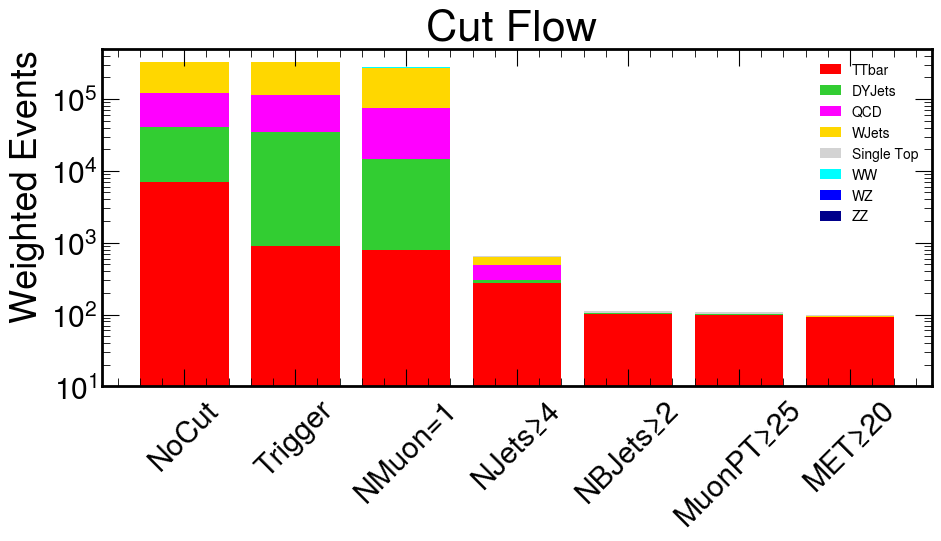

In [192]:
import numpy as np
import matplotlib.pyplot as plt

# Define the desired manual stack order
manual_stack_order = ["TTbar", "DYJets", "QCD", "WJets", "Single Top", "WW", "WZ", "ZZ"]

# Define updated cut labels (must match the columns in your DataFrame)
cut_labels_reordered = ["NoCut", "Trigger", "NMuon=1", "NJets≥4", "NBJets≥2", "MuonPT≥25", "MET≥20"]

# Color scheme for each process
colors = {
    "TTbar": "red",
    "DYJets": "limegreen",
    "QCD": "magenta",
    "WJets": "gold",
    "Single Top": "lightgray",
    "WW": "cyan",
    "WZ": "blue",
    "ZZ": "darkblue"
}

# Initialize bottom for stacking and create the figure
bottom = np.zeros(len(cut_labels_reordered))
fig, ax = plt.subplots(figsize=(10, 6))

# Stack each process in defined order
for proc in manual_stack_order:
    if proc not in df_cutflow_weighted_reordered["Process"].values:
        continue
    values = df_cutflow_weighted_reordered[df_cutflow_weighted_reordered["Process"] == proc][cut_labels_reordered].values.flatten()
    ax.bar(cut_labels_reordered, values, bottom=bottom, label=proc, color=colors.get(proc, "gray"), log=True)
    bottom += values

# Plot styling
ax.set_ylabel("Weighted Events")
ax.set_title("Cut Flow ")
ax.set_yscale("log")
ax.set_ylim(10, None)  # Start y-axis at 10^1
ax.legend(loc="upper right", fontsize=10, frameon=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
df_ttbar=dfs[5]
offline_sel_ttbar, trigger_sel_ttbar, total_ttbar, n_btagged_ttbar = compute_selection(df_ttbar)

# Compute reweighted event weights
weights_reweighted_ttbar = compute_reweighted_weights(df_ttbar, n_btagged_ttbar)

# Trigger efficiency calculation using reweighted events
N_sig_selec_triggered = np.sum(weights_reweighted_ttbar[total_ttbar])
N_sig_selected = np.sum(weights_reweighted_ttbar[offline_sel_ttbar])
total_signal_events = np.sum(weights_reweighted_ttbar)

eff_trigger = N_sig_selec_triggered / N_sig_selected if N_sig_selected > 0 else 0
eff_acceptance = N_sig_selected / total_signal_events if total_signal_events > 0 else 0

# Error calculations (assuming you have a denominator defined properly)
denominator = N_sig_selected
N_gen = len(weights_reweighted_ttbar)  # total generated events

err_trigger = np.sqrt(eff_trigger * (1 - eff_trigger) / denominator) if denominator > 0 else 0

print(f"Trigger efficiency : {eff_trigger:.4f} ± {err_trigger:.4f}")
print(f"Acceptance efficiency : {eff_acceptance:.4f}")


Trigger efficiency : 0.8151 ± 0.0367
Acceptance efficiency : 0.0159


In [6]:
N_sig_selec_triggered

91.30075591004936

In [7]:
N_sig_selected

112.01389327447316

In [8]:
total_signal_events

7033.061683692721

In [10]:

N_selected_bkg = 0
sel_bg_yields=[]
for i, df_bg in enumerate(dfs):
    if df_bg.label == "TTbar" or df_bg.label == "Data":
        continue  # Skip ttbar (signal) and data
     # Compute selection masks and number of b-tagged jets
    offline_mask, trig_mask, total_mask, n_btagged = compute_selection(df_bg)

    # Apply b-tag reweighting factor
    weights_reweighted = df_bg["EventWeight"] * (0.9 ** n_btagged)
    sel_yield_sum = np.sum(weights_reweighted[total_mask])
    N_selected_bkg += sel_yield_sum
    sel_bg_yields.append((df_bg.label, sel_yield_sum))

print(f"Selected Background events: {N_selected_bkg:.2f}")
print("Individual selected Backgrounds:", sel_bg_yields)


Selected Background events: 7.27
Individual selected Backgrounds: [('QCD', 0.0), ('WJets', 2.4660805767774585), ('Single Top', 4.040484551140807), ('WW', 0.0), ('WZ', 0.01945821823552251), ('ZZ', 0.0), ('DYJets', 0.7451377567648888)]


In [11]:
# Data observed events passing full selection criteria
df_data = next(df for df in dfs if df.label == "Data")
offline_d_masking, trig_data, obs_mask, _ = compute_selection(df_data)
N_obs_sel = np.sum(obs_mask)

print(f"Observed events (data): {N_obs_sel}")


Observed events (data): 112


In [13]:
luminosity = 50  # in pb^-1, 
signal_purity= N_sig_selec_triggered/(N_sig_selec_triggered+N_selected_bkg) #signal purity
N_obs= (N_obs_sel-N_selected_bkg)      #number of observed events
N_purity_corr_obs=N_obs_sel*signal_purity    #number of purity corrected observed events

sigma_ttbar=N_obs/(luminosity*eff_trigger*eff_acceptance)

delta_N_obs = np.sqrt(N_obs_sel)  # purely statistical (Poisson)

# Relative uncertainties
rel_uncert_N_obs = delta_N_obs / N_obs if N_obs > 0 else 0
rel_uncert_trigger = err_trigger / eff_trigger if eff_trigger > 0 else 0

# Combined relative uncertainty
relative_uncertainty = np.sqrt(
    rel_uncert_N_obs**2 +
    rel_uncert_trigger**2 
)

# Absolute uncertainty on cross-section
delta_sigma_ttbar = sigma_ttbar * relative_uncertainty
print(f"Signal purity : {signal_purity}")
print(f"Number of Signal observed : {N_obs}")
print(f"Number of purity corrected obs : {N_purity_corr_obs}")

print(f"Cross section of ttbar : {sigma_ttbar} ± {delta_sigma_ttbar:.2f} pb")

Signal purity : 0.92623496302743
Number of Signal observed : 104.72883889708132
Number of purity corrected obs : 103.73831585907216
Cross section of ttbar : 161.34902207170396 ± 17.85 pb


In [19]:
import awkward as ak
import numpy as np
from itertools import combinations

# Proper invariant mass calculation
def invariant_mass(px, py, pz, E):
    mass_squared = E**2 - (px**2 + py**2 + pz**2)
    return np.sqrt(mass_squared) if mass_squared > 0 else 0

# Chi-square calculation for minimization
def chi2_metric(m_w_candidate, m_top_candidate, m_W=80.4, m_top=172.5, sigma_W=10, sigma_t=15):
    return ((m_w_candidate - m_W)**2 / sigma_W**2) + ((m_top_candidate - m_top)**2 / sigma_t**2)

# Minimization-based top mass reconstruction
def compute_mtop_hadronic(df, label="sample", return_weights=False, btag_threshold=0.679):
    _,_,sel_mask,_ = compute_selection(df)
    df_sel = df[sel_mask]

    weights = df_sel["EventWeight"] if "EventWeight" in df_sel.fields else np.ones(len(df_sel))

    px, py, pz, E, btag = (
        df_sel["Jet_Px"], df_sel["Jet_Py"], df_sel["Jet_Pz"], df_sel["Jet_E"], df_sel["Jet_btag"]
    )

    mtop_candidates, event_weights = [], []

    for evt in range(len(df_sel)):
        jets_btag = btag[evt]
        njets = len(jets_btag)
        jet_indices = np.arange(njets)

        bjets = jet_indices[jets_btag > btag_threshold]
        ljets = jet_indices[jets_btag <= btag_threshold]

        best_chi2 = np.inf
        best_mtop = None
        best_bjet = None  # to track hadronic b-jet explicitly

        for i, j in combinations(ljets, 2):
            mjj = invariant_mass(px[evt][i] + px[evt][j], 
                                 py[evt][i] + py[evt][j], 
                                 pz[evt][i] + pz[evt][j], 
                                 E[evt][i]  + E[evt][j])

            for b in bjets:
                mtop = invariant_mass(
                    px[evt][i] + px[evt][j] + px[evt][b],
                    py[evt][i] + py[evt][j] + py[evt][b],
                    pz[evt][i] + pz[evt][j] + pz[evt][b],
                    E[evt][i]  + E[evt][j]  + E[evt][b]
                )

                chi2 = chi2_metric(mjj, mtop)

                if chi2 < best_chi2:
                    best_chi2 = chi2
                    best_mtop = mtop
                    best_bjet = b

        if best_mtop is not None:
            n_btagged = len(bjets)
            weight_reweighted = df_sel["EventWeight"][evt] * (0.9 ** n_btagged)
            mtop_candidates.append(best_mtop)
            event_weights.append(weight_reweighted)

    print(f"{label}: selected {len(mtop_candidates)} events using minimization")
    if return_weights:
        return np.array(mtop_candidates), np.array(event_weights)
    else:
        return np.array(mtop_candidates)


In [20]:
df_data=dfs[0]
df_QCD=dfs[1]
df_WJets=dfs[2]
df_ST=dfs[3]
df_WW=dfs[4]
df_ttbar=dfs[5]
df_WZ=dfs[6]
df_ZZ=dfs[7]
df_DYJ=dfs[8]

# Data (no weights)
mjjj_data = compute_mtop_hadronic(df_data, label="Data")

# MC with weights
mjjj_ttbar, w_ttbar = compute_mtop_hadronic(df_ttbar, label="TTbar", return_weights=True)
mjjj_wjets, w_wjets = compute_mtop_hadronic(df_WJets, label="WJets", return_weights=True)
mjjj_dyj,   w_dyj   = compute_mtop_hadronic(df_DYJ,   label="DYJets", return_weights=True)
mjjj_ww,    w_ww    = compute_mtop_hadronic(df_WW,    label="WW", return_weights=True)
mjjj_wz,    w_wz    = compute_mtop_hadronic(df_WZ,    label="WZ", return_weights=True)
mjjj_zz,    w_zz    = compute_mtop_hadronic(df_ZZ,    label="ZZ", return_weights=True)
mjjj_st,    w_st    = compute_mtop_hadronic(df_ST,    label="Single Top", return_weights=True)
mjjj_qcd,   w_qcd   = compute_mtop_hadronic(df_QCD,   label="QCD", return_weights=True)


Data: selected 103 events using minimization
TTbar: selected 477 events using minimization
WJets: selected 2 events using minimization
DYJets: selected 2 events using minimization
WW: selected 0 events using minimization
WZ: selected 1 events using minimization
ZZ: selected 0 events using minimization
Single Top: selected 92 events using minimization
QCD: selected 0 events using minimization


In [21]:
import numpy as np

# CMS-style binning
xmin, xmax = 100, 300
nbins = 40
bin_edges = np.linspace(xmin, xmax, nbins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Helper for weighted histograms
def weighted_hist(data, weights):
    h, _ = np.histogram(data, bins=bin_edges, weights=weights)
    h_err = np.sqrt(np.histogram(data, bins=bin_edges, weights=weights**2)[0])
    return h, h_err

# Create histograms
h_data1, _ = np.histogram(mjjj_data, bins=bin_edges)
h_data_err1 = np.sqrt(h_data1)

h_ttbar1, h_ttbar_err1 = weighted_hist(mjjj_ttbar, w_ttbar)
h_wjets1, h_wjets_err1 = weighted_hist(mjjj_wjets, w_wjets)
h_dyj1, h_dyj_err1 = weighted_hist(mjjj_dyj, w_dyj)
h_ww1, h_ww_err1 = weighted_hist(mjjj_ww, w_ww)
h_wz1, h_wz_err1 = weighted_hist(mjjj_wz, w_wz)
h_zz1, h_zz_err1 = weighted_hist(mjjj_zz, w_zz)
h_st1, h_st_err1 = weighted_hist(mjjj_st, w_st)
h_qcd1, h_qcd_err1 = weighted_hist(mjjj_qcd, w_qcd)

mc_histograms1 = {
    'TTbar':      (h_ttbar1, h_ttbar_err1, '#ff0000'),
    'WJets':      (h_wjets1, h_wjets_err1, '#79b278'),
    'DYJets':     (h_dyj1,   h_dyj_err1,   '#f0f423'),
    'WW':         (h_ww1,    h_ww_err1,    '#6b59d3'),
    'WZ':         (h_wz1,    h_wz_err1,    'orange'),
    'ZZ':         (h_zz1,    h_zz_err1,    '#baff8d'),
    'Single Top': (h_st1,    h_st_err1,    '#00cdff'),
    'QCD':        (h_qcd1,   h_qcd_err1,   '#a9a9a9')
}


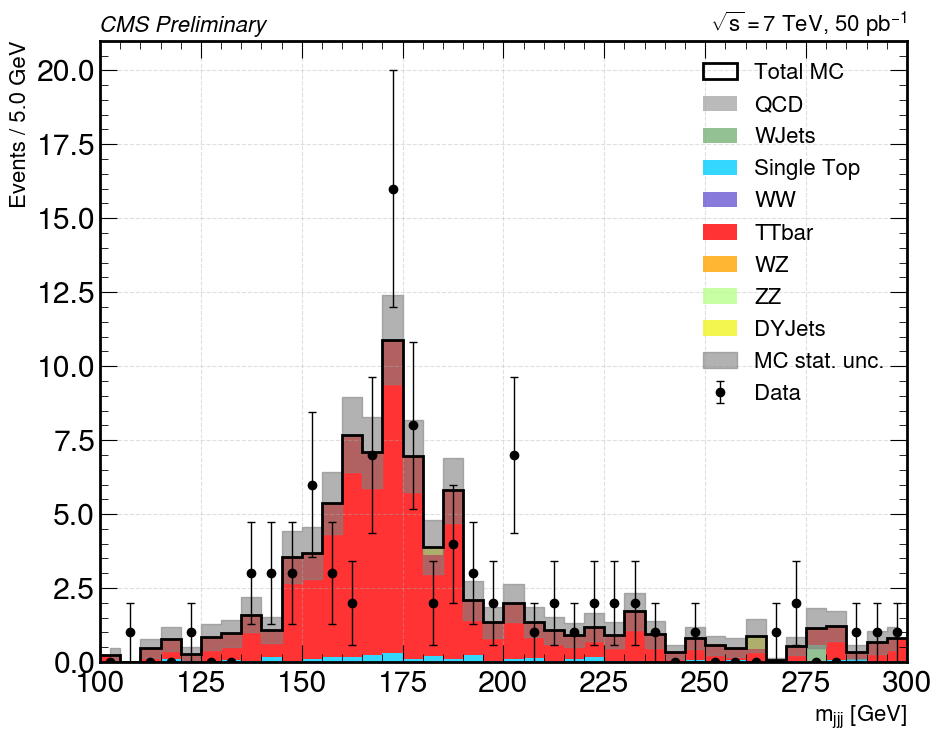

In [226]:
import matplotlib.pyplot as plt
import numpy as np

# Plot settings
plt.figure(figsize=(10, 8))
bin_width = bin_edges[1] - bin_edges[0]

# Stack backgrounds (order matters for correct stacking)
bkg_order = ['QCD', 'WJets', 'Single Top', 'WW', 'TTbar', 'WZ', 'ZZ', 'DYJets']
stack_vals = []
stack_errs = []
colors = []
labels = []

for key in bkg_order:
    hist, err, color = mc_histograms1[key]
    stack_vals.append(hist)
    stack_errs.append(err)
    colors.append(color)
    labels.append(key)

# Compute total MC and total error
total_mc = np.sum(stack_vals, axis=0)
total_mc_err = np.sqrt(np.sum(np.square(stack_errs), axis=0))

# Plot stacked histogram outline (step)
_, bins, _ = plt.hist(
    bin_centers,
    bins=bin_edges,
    weights=total_mc,
    histtype='step',
    color='black',
    linewidth=2,
    label='Total MC'
)

# Stacked background fill
plt.hist(
    [bin_centers]*len(stack_vals),
    bins=bin_edges,
    weights=stack_vals,
    stacked=True,
    color=colors,
    label=labels,
    alpha=0.8
)

# MC statistical uncertainty band
plt.fill_between(
    bin_centers,
    total_mc - total_mc_err,
    total_mc + total_mc_err,
    step='mid',
    color='gray',
    alpha=0.6,
    label='MC stat. unc.'
)

# Data points
plt.errorbar(
    bin_centers, h_data1,
    yerr=h_data_err1,
    fmt='o', color='black', label='Data',
    capsize=3, markersize=6, linewidth=1
)

# Labels and CMS-style formatting
plt.xlabel(r"$m_{jjj}$ [GeV]", fontsize=16)
plt.ylabel("Events / %.1f GeV" % bin_width, fontsize=16)
plt.title("CMS Preliminary", loc='left', fontsize=16, style='italic')
plt.title(r"$\sqrt{s} = 7$ TeV, 50 pb$^{-1}$", loc='right', fontsize=16)
plt.legend(fontsize=16, loc='upper right', bbox_to_anchor=(1.0, 1.0))
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlim(xmin, xmax)
plt.tight_layout()
# Save to file
plt.savefig("mjjj_plot.png", dpi=90, bbox_inches='tight')  # or use .pdf, .eps etc.

plt.show()


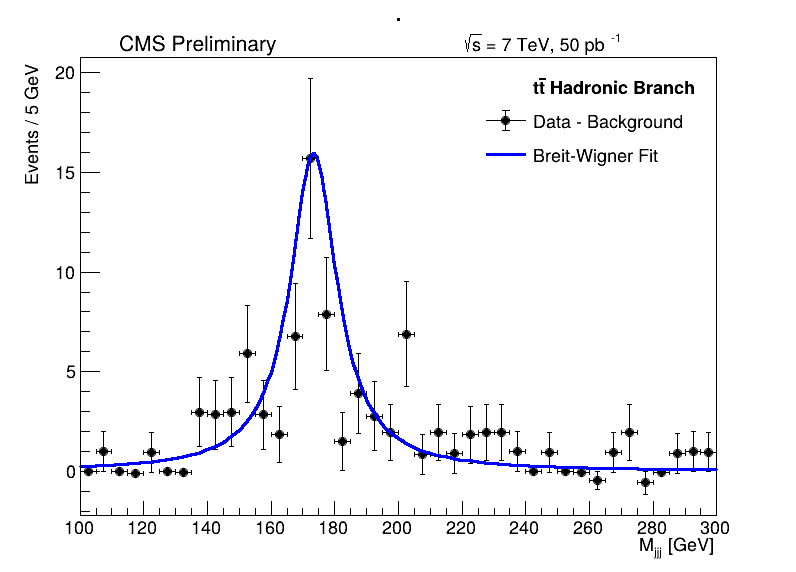

Top Mass = 173.35 ± 1.53 GeV
Width    = 18.00 ± 0.01 GeV
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(dh_data): fit range of variable mass expanded to nearest bin boundaries: [100,310] --> [100,300]
[#1] INFO:Minimization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Fitting -- RooAbsPdf::fitTo(model) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model_dh_data) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
Minuit2Minimizer: Minimize with max-calls 1500 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 130.940203167463039
Edm   = 0.000678958863082284258
Nfcn  = 75
gamma	  = 17.9999	 +/-  0.38896	(limited)
m_bw	  = 173.353	 +/-  1.50973	(limited)
nsig	  = 84.634	 +/-  9.19967	(limited)
[#1] INFO:Fitting -- 

Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ttbar (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_bkg (Potential memory leak).
Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =        190.804433 Edm =      -6.856238163 NCalls =     13
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 148.9778468
  Edm           : 11.60583757
  Internal parameters:	[    0.05885750595     0.7621000673     -1.552396718]	
  Internal gradient  :	[     -31.99441531       12.8884366 -0.0006457824155]	
  Internal covariance matrix:
[[    0.043584762              0              0]
 [              0    0.010885024              0]
 [              0          

In [24]:
import ROOT
from ROOT import RooRealVar, RooDataHist, RooArgList, RooBreitWigner, RooAddPdf, RooFit, TCanvas, TLegend, TLatex
from IPython.display import Image, display

# Define binning
nbins = 40
xmin = 100
xmax = 300

# Fill histograms
h_data = ROOT.TH1F("h_data", "Data", nbins, xmin, xmax)
h_ttbar = ROOT.TH1F("h_ttbar", "TTbar", nbins, xmin, xmax)
h_bkg = ROOT.TH1F("h_bkg", "Background", nbins, xmin, xmax)

for x in mjjj_data: h_data.Fill(x)
for x, w in zip(mjjj_ttbar, w_ttbar): h_ttbar.Fill(x, w)
for mjjj, wgt in [(mjjj_wjets, w_wjets), (mjjj_dyj, w_dyj), (mjjj_ww, w_ww), (mjjj_wz, w_wz),
                  (mjjj_zz, w_zz), (mjjj_st, w_st), (mjjj_qcd, w_qcd)]:
    for x, w in zip(mjjj, wgt):
        h_bkg.Fill(x, w)

# Observable
mass = RooRealVar("mass", "M_{jjj} [GeV]", 100, 310)


# Subtract background
h_data_sub = h_data.Clone("h_data_sub")
h_data_sub.Add(h_bkg, -1)

# Convert to RooDataHist
dh_data = RooDataHist("dh_data", "Data - Background", RooArgList(mass), h_data_sub)

# Signal: Breit-Wigner
m_bw = RooRealVar("m_bw", "Top Mass", 160.0, 140.0, 180.0)
gamma = RooRealVar("gamma", "Width", 10.0, 1.0, 18.0)
bw = RooBreitWigner("bw", "Breit-Wigner", mass, m_bw, gamma)

nsig = RooRealVar("nsig", "Signal Yield", h_data_sub.Integral(), 0, 1e6)
model = RooAddPdf("model", "Signal Only", RooArgList(bw), RooArgList(nsig))
model.fitTo(dh_data, RooFit.SumW2Error(True))

# Plot
frame = mass.frame(RooFit.Title("."))
dh_data.plotOn(frame, RooFit.Name("data"))
model.plotOn(frame, RooFit.Name("fit"))
model.plotOn(frame, RooFit.Components("bw"), RooFit.LineColor(ROOT.kBlue), RooFit.LineStyle(ROOT.kDotted), RooFit.Name("signal"))
frame.GetYaxis().SetTitle("Events / 5 GeV")  # Change y-axis label here
# Canvas
c = TCanvas("c", "BW Fit", 800, 600)
frame.Draw()

# CMS Text
latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.04)
latex.SetTextFont(42)
latex.DrawLatex(0.15, 0.91, "CMS Preliminary")
latex.SetTextSize(0.035)
latex.DrawLatex(0.58, 0.91, "#sqrt{s} = 7 TeV, 50 pb^{-1}")

# Legend
legend = TLegend(0.6, 0.7, 0.88, 0.88)
#legend.SetTextFont(62) 
# Add custom title (no marker, just text)
legend.AddEntry(0, "#font[62]{t#bar{t} Hadronic Branch}", "")  

# Then the usual entries
legend.AddEntry(frame.findObject("data"), "Data - Background", "lep")
legend.AddEntry(frame.findObject("fit"), "Breit-Wigner Fit", "l")


legend.SetBorderSize(0)
legend.SetFillStyle(0)
legend.SetTextSize(0.035)
legend.Draw()

# Save and show
c.SaveAs("cms_breit_wigner_hadronic_top_fit.png")
display(Image(filename="cms_breit_wigner_hadronic_top_fit.png"))

# Print
print(f"Top Mass = {m_bw.getVal():.2f} ± {m_bw.getError():.2f} GeV")
print(f"Width    = {gamma.getVal():.2f} ± {gamma.getError():.2f} GeV")


In [27]:
def reconstruct_leptonic_top_masses_and_weights_selected(df, label="sample", btag_threshold=0.679):

    _, _, selection,_ = compute_selection(df)
    df_sel = df[selection]

    leptonic_top_masses = []
    leptonic_weights = []

    mW = 80.4  # W boson mass in GeV
    mu_mass = 0.105
    nu_mass = 0.0

    for i in range(len(df_sel["Muon_Px"])):
        if len(df_sel["Muon_Px"][i]) == 0 or len(df_sel["Jet_Px"][i]) == 0:
            continue

        mu_px = df_sel["Muon_Px"][i][0]
        mu_py = df_sel["Muon_Py"][i][0]
        mu_pz = df_sel["Muon_Pz"][i][0]
        mu_e  = np.sqrt(mu_px**2 + mu_py**2 + mu_pz**2 + mu_mass**2)

        met_px = df_sel["MET_px"][i]
        met_py = df_sel["MET_py"][i]

        # Solve quadratic equation for neutrino pz
        a = 4 * (mu_e**2 - mu_pz**2)
        b = 4 * mu_pz * (mW**2 - 2 * (mu_px * met_px + mu_py * met_py))
        c = (mW**2 - 2 * (mu_px * met_px + mu_py * met_py))**2 - 4 * mu_e**2 * (met_px**2 + met_py**2)

        discriminant = b**2 - 4*a*c
        if discriminant < 0:
            continue

        sqrt_disc = np.sqrt(discriminant)
        pz_nu_1 = (-b + sqrt_disc) / (2*a)
        pz_nu_2 = (-b - sqrt_disc) / (2*a)

        neutrino_solutions = [pz_nu_1, pz_nu_2]

        best_chi2 = np.inf
        best_mtop = None

        for pz_nu in neutrino_solutions:
            e_nu = np.sqrt(met_px**2 + met_py**2 + pz_nu**2 + nu_mass**2)

            for bidx in range(len(df_sel["Jet_Px"][i])):
                b_px = df_sel["Jet_Px"][i][bidx]
                b_py = df_sel["Jet_Py"][i][bidx]
                b_pz = df_sel["Jet_Pz"][i][bidx]
                b_e  = df_sel["Jet_E"][i][bidx]

                top_px = mu_px + met_px + b_px
                top_py = mu_py + met_py + b_py
                top_pz = mu_pz + pz_nu + b_pz
                top_e  = mu_e + e_nu + b_e

                m_top = np.sqrt(top_e**2 - top_px**2 - top_py**2 - top_pz**2)

                chi2 = ((m_top - 172.5)**2) / (15**2)  # sigma_t ~ 15 GeV

                if chi2 < best_chi2:
                    best_chi2 = chi2
                    best_mtop = m_top

        if best_mtop:
            n_btagged = np.sum(df_sel["Jet_btag"][i] > btag_threshold)
            event_weight = df_sel["EventWeight"][i] * (0.9 ** n_btagged) if "EventWeight" in df_sel.fields else (0.9 ** n_btagged)

            leptonic_top_masses.append(best_mtop)
            leptonic_weights.append(event_weight)

    print(f"{label}: selected {len(leptonic_top_masses)} events with minimization and reweighting")
    return np.array(leptonic_top_masses), np.array(leptonic_weights)


In [28]:
# Apply selection + reconstruction

# Data
mlep_data, w1_data = reconstruct_leptonic_top_masses_and_weights_selected(df_data,label="Data")

# MC
mlep_ttbar, w1_ttbar = reconstruct_leptonic_top_masses_and_weights_selected(df_ttbar, label="TTbar")
mlep_wjets, w1_wjets = reconstruct_leptonic_top_masses_and_weights_selected(df_WJets, label="WJets")
mlep_dyj,   w1_dyj   = reconstruct_leptonic_top_masses_and_weights_selected(df_DYJ,   label="DYJets")
mlep_ww,    w1_ww    = reconstruct_leptonic_top_masses_and_weights_selected(df_WW,    label="WW")
mlep_wz,    w1_wz    = reconstruct_leptonic_top_masses_and_weights_selected(df_WZ,    label="ZZ")
mlep_zz,    w1_zz    = reconstruct_leptonic_top_masses_and_weights_selected(df_ZZ,    label="Single Top")
mlep_st,    w1_st    = reconstruct_leptonic_top_masses_and_weights_selected(df_ST,    label="Single Top")
mlep_qcd,   w1_qcd   = reconstruct_leptonic_top_masses_and_weights_selected(df_QCD,   label="QCD")


Data: selected 85 events with minimization and reweighting
TTbar: selected 405 events with minimization and reweighting
WJets: selected 2 events with minimization and reweighting
DYJets: selected 0 events with minimization and reweighting
WW: selected 0 events with minimization and reweighting
ZZ: selected 1 events with minimization and reweighting
Single Top: selected 0 events with minimization and reweighting
Single Top: selected 78 events with minimization and reweighting
QCD: selected 0 events with minimization and reweighting


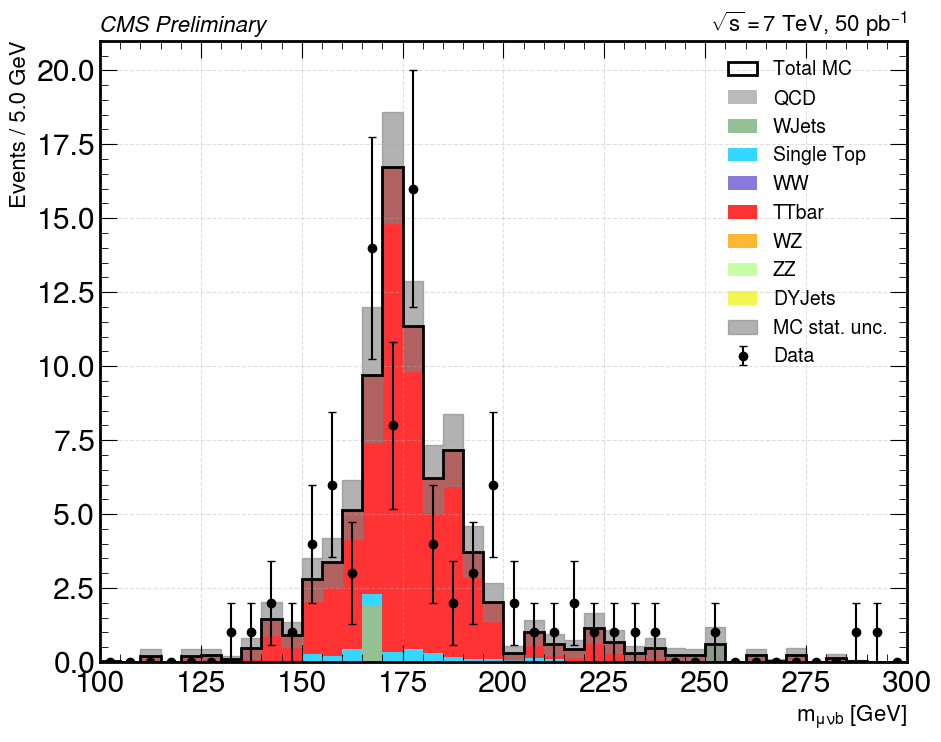

In [227]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Define binning
xmin, xmax = 100, 300
nbins = 40
bin_edges = np.linspace(xmin, xmax, nbins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Data histogram
h_data, _ = np.histogram(mlep_data, bins=bin_edges)
h_data_err = np.sqrt(h_data)

# MC histograms
def hist_and_err(values, weights):
    hist, _ = np.histogram(values, bins=bin_edges, weights=weights)
    err = np.sqrt(np.histogram(values, bins=bin_edges, weights=weights**2)[0])
    return hist, err

h_ttbar, h_ttbar_err = hist_and_err(mlep_ttbar, w1_ttbar)
h_wjets, h_wjets_err = hist_and_err(mlep_wjets, w1_wjets)
h_dyj, h_dyj_err = hist_and_err(mlep_dyj, w1_dyj)
h_ww, h_ww_err = hist_and_err(mlep_ww, w1_ww)
h_wz, h_wz_err = hist_and_err(mlep_wz, w1_wz)
h_zz, h_zz_err = hist_and_err(mlep_zz, w1_zz)
h_st, h_st_err = hist_and_err(mlep_st, w1_st)
h_qcd, h_qcd_err = hist_and_err(mlep_qcd, w1_qcd)

mc_histograms = {
    'TTbar':      (h_ttbar, h_ttbar_err, '#ff0000'),
    'WJets':      (h_wjets, h_wjets_err, '#79b278'),
    'DYJets':     (h_dyj,   h_dyj_err,   '#f0f423'),
    'WW':         (h_ww,    h_ww_err,    '#6b59d3'),
    'WZ':         (h_wz,    h_wz_err,    'orange'),
    'ZZ':         (h_zz,    h_zz_err,    '#baff8d'),
    'Single Top': (h_st,    h_st_err,    '#00cdff'),
    'QCD':        (h_qcd,   h_qcd_err,   '#a9a9a9')
}

# Plot
plt.figure(figsize=(10, 8))
bin_width = bin_edges[1] - bin_edges[0]

bkg_order = ['QCD', 'WJets', 'Single Top', 'WW', 'TTbar', 'WZ', 'ZZ', 'DYJets']
stack_vals, stack_errs, colors, labels = [], [], [], []

for key in bkg_order:
    h, e, c = mc_histograms[key]
    stack_vals.append(h)
    stack_errs.append(e)
    colors.append(c)
    labels.append(key)

total_mc = np.sum(stack_vals, axis=0)
total_mc_err = np.sqrt(np.sum(np.square(stack_errs), axis=0))

# Step outline
plt.hist(bin_centers, bins=bin_edges, weights=total_mc, histtype='step', color='black', linewidth=2, label='Total MC')

# Stacked bars
plt.hist([bin_centers]*len(stack_vals), bins=bin_edges, weights=stack_vals, stacked=True, color=colors, label=labels, alpha=0.8)

# MC uncertainty band
plt.fill_between(bin_centers, total_mc - total_mc_err, total_mc + total_mc_err, step='mid', color='gray', alpha=0.6, label='MC stat. unc.')

# Data
plt.errorbar(bin_centers, h_data, yerr=h_data_err, fmt='o', color='black', label='Data', capsize=3, markersize=6)

# Labels
plt.xlabel(r"$m_{\mu\nu b}$ [GeV]", fontsize=16)
plt.ylabel("Events / %.1f GeV" % bin_width, fontsize=16)
plt.title("CMS Preliminary", loc='left', fontsize=16, style='italic')
plt.title(r"$\sqrt{s} = 7$ TeV, 50 pb$^{-1}$", loc='right', fontsize=16)

plt.legend(fontsize=14, loc='upper right')
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlim(xmin, xmax)
plt.tight_layout()
plt.savefig("mlll_plot.png", dpi=90, bbox_inches='tight')  # or use .pdf, .eps etc.
plt.show()

Top Mass (BW mean) = 174.05 ± 1.59 GeV
Width (BW gamma)   = 17.00 ± 0.00 GeV


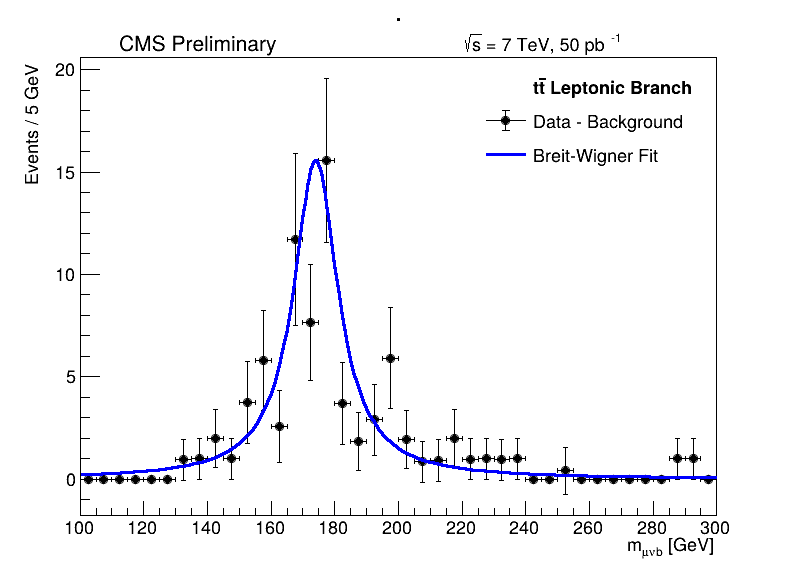

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(dh2_subtracted): fit range of variable mass expanded to nearest bin boundaries: [100,310] --> [100,300]
[#1] INFO:Fitting -- RooAbsPdf::fitTo(bw_pdf_over_bw_pdf_Int[mass]) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_bw_pdf_over_bw_pdf_Int[mass]_dh2_subtracted) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
Minuit2Minimizer: Minimize with max-calls 1000 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 360.028174583127054
Edm   = 9.19734231271716059e-08
Nfcn  = 36
gamma	  = 17	 +/-  0.643868	(limited)
m_bw	  = 174.051	 +/-  1.53363	(limited)
[#1] INFO:Fitting -- RooAbsPdf::fitTo(bw_pdf) Calculating sum-of-weights-squared correction matrix for covariance matrix
[#1] INFO:Minimization -- RooAbsMinimizerFcn::set

Warning in <TROOT::Append>: Replacing existing TH1: h2_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2_ttbar (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2_bkg (Potential memory leak).
Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       362.5077869 Edm =        2.11273866 NCalls =      7
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 362.5077869
  Edm           : 2.11273866
  Internal parameters:	[     0.7297276562                0]	
  Internal gradient  :	[     -5.400192386     -8.909031372]	
  Internal covariance matrix:
[[     0.20667361              0]
 [              0     0.03053921]]]
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 1000
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =       362.5077869 Edm =        2.11273866 NCalls =      7
I

In [32]:
import ROOT
from ROOT import RooRealVar, RooDataHist, RooArgList, RooBreitWigner, RooFit, TCanvas, TLegend

# -----------------------------
# Histogram Parameters
# -----------------------------
nbins = 40
xmin = 100
xmax = 300

# -----------------------------
# Create histograms
# -----------------------------
h2_data = ROOT.TH1F("h2_data", "Leptonic Top Mass (Data)", nbins, xmin, xmax)
h2_ttbar = ROOT.TH1F("h2_ttbar", "Leptonic Top Mass (TTbar)", nbins, xmin, xmax)
h2_bkg = ROOT.TH1F("h2_bkg", "Leptonic Top Mass (Background)", nbins, xmin, xmax)

# -----------------------------
# Fill histograms
# -----------------------------
for m in mlep_data:
    h2_data.Fill(m)

for m, w in zip(mlep_ttbar, w1_ttbar):
    h2_ttbar.Fill(m, w)

bkg2_samples = [
    (mlep_wjets, w1_wjets),
    (mlep_dyj,   w1_dyj),
    (mlep_ww,    w1_ww),
    (mlep_wz,    w1_wz),
    (mlep_zz,    w1_zz),
    (mlep_st,    w1_st),
    (mlep_qcd,   w1_qcd),
]

for m_sample, w_sample in bkg2_samples:
    for m, w in zip(m_sample, w_sample):
        h2_bkg.Fill(m, w)


# Step 1: Define the mass observable
mass = RooRealVar("mass", "m_{#mu#nub} [GeV]", 100, 310)

# Step 2: Subtract background from data
h2_subtracted = h2_data.Clone("h2_subtracted")
h2_subtracted.Add(h2_bkg, -1)

# Set negative bins to zero
for i in range(1, h2_subtracted.GetNbinsX() + 1):
    if h2_subtracted.GetBinContent(i) < 0:
        h2_subtracted.SetBinContent(i, 0)

# Step 3: Convert to RooDataHist
dh2_subtracted = RooDataHist("dh2_subtracted", "Data - Background", RooArgList(mass), h2_subtracted)

# Step 4: Define Breit-Wigner PDF
m_bw = RooRealVar("m_bw", "Top Mass Mean", 172.5, 160, 185)
gamma = RooRealVar("gamma", "Width", 15, 5, 17)
bw_pdf = RooBreitWigner("bw_pdf", "Breit-Wigner PDF", mass, m_bw, gamma)

# Step 5: Fit to data
bw_pdf.fitTo(dh2_subtracted, RooFit.SumW2Error(True))

# Step 6: Plotting
frame = mass.frame(RooFit.Title("."))  # Empty title if you don't want one
frame.GetYaxis().SetTitle("Events / 5 GeV")  # Change y-axis label here

dh2_subtracted.plotOn(frame, RooFit.Name("data_subtracted"))
bw_pdf.plotOn(frame, RooFit.Name("bw_fit"))

# Canvas
c2 = TCanvas("c2", "BW Fit", 800, 600)
frame.Draw()

# CMS Text
latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.04)
latex.SetTextFont(42)
latex.DrawLatex(0.15, 0.91, "CMS Preliminary")
latex.SetTextSize(0.035)
latex.DrawLatex(0.58, 0.91, "#sqrt{s} = 7 TeV, 50 pb^{-1}")

# Legend
legend = TLegend(0.6, 0.7, 0.88, 0.88)
#legend.SetTextFont(62) 
# Add custom title (no marker, just text)
legend.AddEntry(0, "#font[62]{t#bar{t} Leptonic Branch}", "")  

# Then the usual entries
legend.AddEntry(frame.findObject("data_subtracted"), "Data - Background", "lep")
legend.AddEntry(frame.findObject("bw_fit"), "Breit-Wigner Fit", "l")

legend.SetBorderSize(0)
legend.SetFillStyle(0)
legend.SetTextSize(0.035)
legend.Draw()


# Save and print
c2.SaveAs("leptonic_signal_bw_fit1.png")
print(f"Top Mass (BW mean) = {m_bw.getVal():.2f} ± {m_bw.getError():.2f} GeV")
print(f"Width (BW gamma)   = {gamma.getVal():.2f} ± {gamma.getError():.2f} GeV")



display(Image(filename="leptonic_signal_bw_fit1.png"))



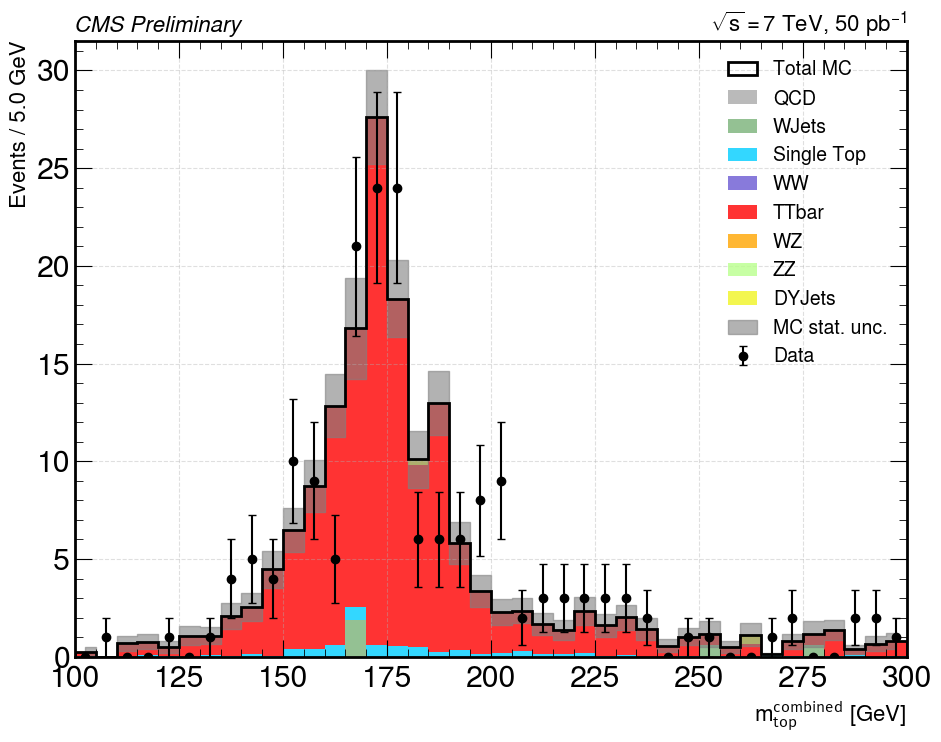

In [229]:
import numpy as np
import matplotlib.pyplot as plt

# Combine data histograms
h_data_combined = h_data + h_data1
h_data_err_combined = np.sqrt(h_data_err**2 + h_data_err1**2)

# Combine MC histograms
mc_histograms_combined = {}
for key in mc_histograms:
    h1, err1, col = mc_histograms[key]
    h2, err2, _ = mc_histograms1[key]
    h_comb = h1 + h2
    err_comb = np.sqrt(err1**2 + err2**2)
    mc_histograms_combined[key] = (h_comb, err_comb, col)

# Plot setup
plt.figure(figsize=(10, 8))
bin_width = bin_edges[1] - bin_edges[0]

bkg_order = ['QCD', 'WJets', 'Single Top', 'WW', 'TTbar', 'WZ', 'ZZ', 'DYJets']
stack_vals, stack_errs, colors, labels = [], [], [], []

for key in bkg_order:
    h, e, c = mc_histograms_combined[key]
    stack_vals.append(h)
    stack_errs.append(e)
    colors.append(c)
    labels.append(key)

total_mc = np.sum(stack_vals, axis=0)
total_mc_err = np.sqrt(np.sum(np.square(stack_errs), axis=0))

# Step outline
plt.hist(bin_centers, bins=bin_edges, weights=total_mc, histtype='step', color='black', linewidth=2, label='Total MC')

# Stacked bars
plt.hist([bin_centers]*len(stack_vals), bins=bin_edges, weights=stack_vals, stacked=True, color=colors, label=labels, alpha=0.8)

# MC uncertainty band
plt.fill_between(bin_centers, total_mc - total_mc_err, total_mc + total_mc_err, step='mid', color='gray', alpha=0.6, label='MC stat. unc.')

# Data
plt.errorbar(bin_centers, h_data_combined, yerr=h_data_err_combined, fmt='o', color='black', label='Data', capsize=3, markersize=6)

# Labels
plt.xlabel(r"$m_{\text{top}}^\text{combined}$ [GeV]", fontsize=16)
plt.ylabel("Events / %.1f GeV" % bin_width, fontsize=16)
plt.title("CMS Preliminary", loc='left', fontsize=16, style='italic')
plt.title(r"$\sqrt{s} = 7$ TeV, 50 pb$^{-1}$", loc='right', fontsize=16)

plt.legend(fontsize=14, loc='upper right')
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlim(xmin, xmax)
plt.tight_layout()
plt.savefig("mcombined_plot.png", dpi=90, bbox_inches='tight')  # or use .pdf, .eps etc.
plt.show()


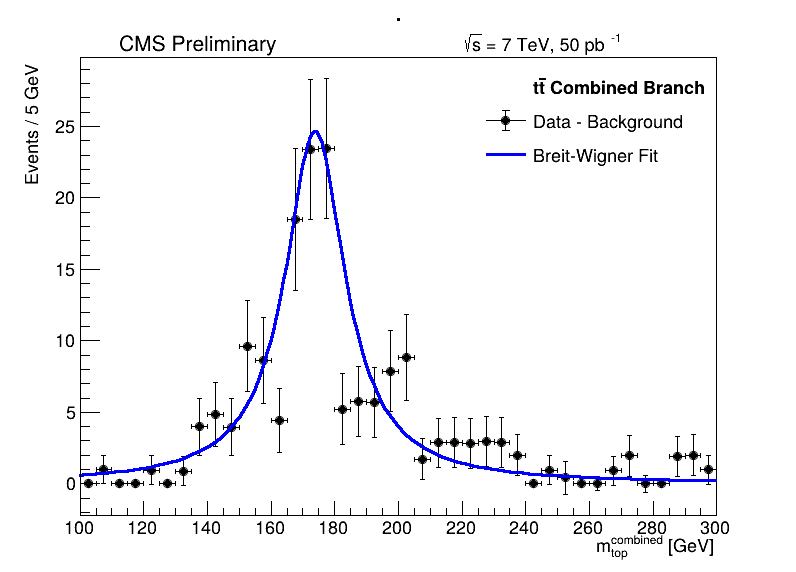

Top Mass (BW mean) = 173.84 ± 1.32 GeV
Width (BW gamma)   = 23.00 ± 0.00 GeV
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(dh_sub_comb): fit range of variable mass expanded to nearest bin boundaries: [100,310] --> [100,300]
[#1] INFO:Fitting -- RooAbsPdf::fitTo(bw_pdf_over_bw_pdf_Int[mass]) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_bw_pdf_over_bw_pdf_Int[mass]_dh_sub_comb) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
Minuit2Minimizer: Minimize with max-calls 1000 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 783.864759014525248
Edm   = 5.76311084373322855e-05
Nfcn  = 42
gamma	  = 23	 +/-  0.553712	(limited)
m_bw	  = 173.839	 +/-  1.27245	(limited)
[#1] INFO:Fitting -- RooAbsPdf::fitTo(bw_pdf) Calculating sum-of-weights-squared correction matrix 

Warning in <TROOT::Append>: Replacing existing TH1: h_data_comb (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ttbar_comb (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_bkg_comb (Potential memory leak).
Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       798.8057833 Edm =       10.02943753 NCalls =      9
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 798.8057833
  Edm           : 10.02943753
  Internal parameters:	[     0.1113410143                0]	
  Internal gradient  :	[     -27.86899619     -13.97846272]	
  Internal covariance matrix:
[[    0.048435208              0]
 [              0    0.012789558]]]
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 1000
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =       798.8057833 Edm =       10.02943753 NCal

In [223]:
import ROOT
from ROOT import RooRealVar, RooDataHist, RooArgList, RooBreitWigner, RooFit, TCanvas, TLegend, TLatex

# Histogram Parameters
nbins = 40
xmin = 100
xmax = 300

# Create combined histograms
h_data_comb = ROOT.TH1F("h_data_comb", "Combined Top Mass (Data)", nbins, xmin, xmax)
h_ttbar_comb = ROOT.TH1F("h_ttbar_comb", "Combined Top Mass (TTbar)", nbins, xmin, xmax)
h_bkg_comb = ROOT.TH1F("h_bkg_comb", "Combined Top Mass (Background)", nbins, xmin, xmax)

# Fill combined histograms with hadronic and leptonic components
for m in np.concatenate([mlep_data, mjjj_data]):
    h_data_comb.Fill(m)

for m, w in zip(np.concatenate([mlep_ttbar, mjjj_ttbar]), np.concatenate([w1_ttbar, w_ttbar])):
    h_ttbar_comb.Fill(m, w)

bkg_combined_samples = [
    (np.concatenate([mlep_wjets, mjjj_wjets]), np.concatenate([w1_wjets, w_wjets])),
    (np.concatenate([mlep_dyj, mjjj_dyj]),     np.concatenate([w1_dyj, w_dyj])),
    (np.concatenate([mlep_ww, mjjj_ww]),       np.concatenate([w1_ww, w_ww])),
    (np.concatenate([mlep_wz, mjjj_wz]),       np.concatenate([w1_wz, w_wz])),
    (np.concatenate([mlep_zz, mjjj_zz]),       np.concatenate([w1_zz, w_zz])),
    (np.concatenate([mlep_st, mjjj_st]),       np.concatenate([w1_st, w_st])),
    (np.concatenate([mlep_qcd, mjjj_qcd]),     np.concatenate([w1_qcd, w_qcd])),
]

for masses, weights in bkg_combined_samples:
    for m, w in zip(masses, weights):
        h_bkg_comb.Fill(m, w)

# Step 1: Define mass observable
mass = RooRealVar("mass", "m_{top}^{combined} [GeV]", 100, 310)

# Step 2: Subtract background from data
h_sub_comb = h_data_comb.Clone("h_sub_comb")
h_sub_comb.Add(h_bkg_comb, -1)

for i in range(1, h_sub_comb.GetNbinsX() + 1):
    if h_sub_comb.GetBinContent(i) < 0:
        h_sub_comb.SetBinContent(i, 0)

# Step 3: Convert to RooDataHist
dh_sub_comb = RooDataHist("dh_sub_comb", "Data - Background", RooArgList(mass), h_sub_comb)

# Step 4: Define Breit-Wigner PDF
m_bw = RooRealVar("m_bw", "Top Mass Mean", 172.5, 160, 185)
gamma = RooRealVar("gamma", "Width", 15, 5, 23)
bw_pdf = RooBreitWigner("bw_pdf", "Breit-Wigner PDF", mass, m_bw, gamma)

# Step 5: Fit to data
bw_pdf.fitTo(dh_sub_comb, RooFit.SumW2Error(True))

# Step 6: Plotting
frame = mass.frame(RooFit.Title("."))
frame.GetYaxis().SetTitle("Events / 5 GeV")
dh_sub_comb.plotOn(frame, RooFit.Name("data_subtracted"))
bw_pdf.plotOn(frame, RooFit.Name("bw_fit"))

c3 = TCanvas("c3", "Combined BW Fit", 800, 600)
frame.Draw()

# CMS Text
latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.04)
latex.SetTextFont(42)
latex.DrawLatex(0.15, 0.91, "CMS Preliminary")
latex.SetTextSize(0.035)
latex.DrawLatex(0.58, 0.91, "#sqrt{s} = 7 TeV, 50 pb^{-1}")

# Legend
legend = TLegend(0.6, 0.7, 0.88, 0.88)
legend.AddEntry(0, "#font[62]{t#bar{t} Combined Branch}", "")
legend.AddEntry(frame.findObject("data_subtracted"), "Data - Background", "lep")
legend.AddEntry(frame.findObject("bw_fit"), "Breit-Wigner Fit", "l")
legend.SetBorderSize(0)
legend.SetFillStyle(0)
legend.SetTextSize(0.035)
legend.Draw()

# Save and print
c3.SaveAs("combined_signal_bw_fit.png")
display(Image(filename="combined_signal_bw_fit.png"))
print(f"Top Mass (BW mean) = {m_bw.getVal():.2f} ± {m_bw.getError():.2f} GeV")
print(f"Width (BW gamma)   = {gamma.getVal():.2f} ± {gamma.getError():.2f} GeV")
